# Using ArchGDAL to read and write Rasters

This notebook is all about reading displaying and writting rasters using GDAL in Julia <del>1.1.0</del> 1.7.0 - update 17/12/2021 <br>

<b>I have made some significant adjustments to this notebook (18/12/2021). I've got a few other things to look at but this should be better than previous.</b>

I am primarily using ArchGDAL, which is available from here https://github.com/yeesian/ArchGDAL.jl please do visit this page. Please see the blog post associated to this series for further information and background.

If you are familiar with GDAL and Rasterio within Python then this should all be similar. ArchGDAL aims to build on top of GDAL providing a high level API

First off lets take a look at GDAL.jl

In [1]:
using GDAL
dataset = GDAL.gdalopen("D:/Julia_Geospatial/Isle_wight.tif", GDAL.GA_ReadOnly)
print(dataset)

Ptr{Nothing} @0x000000001b738b30

We can open the Isle_wight.tif in GDAL. By printing the dataset we can see that it is a GDAL object.
<br>This data is a Sentinel2a 3 band RGB true colour image</br>

We can access 1 band using the getrasterband command

In [2]:
band = GDAL.gdalgetrasterband(dataset, 1)
print(band)

Ptr{Nothing} @0x000000003d8ac790

Check out more about the GDAL package here https://github.com/JuliaGeo/GDAL.jl for now we will move on onwards with ArchGDAL. First though lets view our raster like its a 'normal' ie non geotiff image

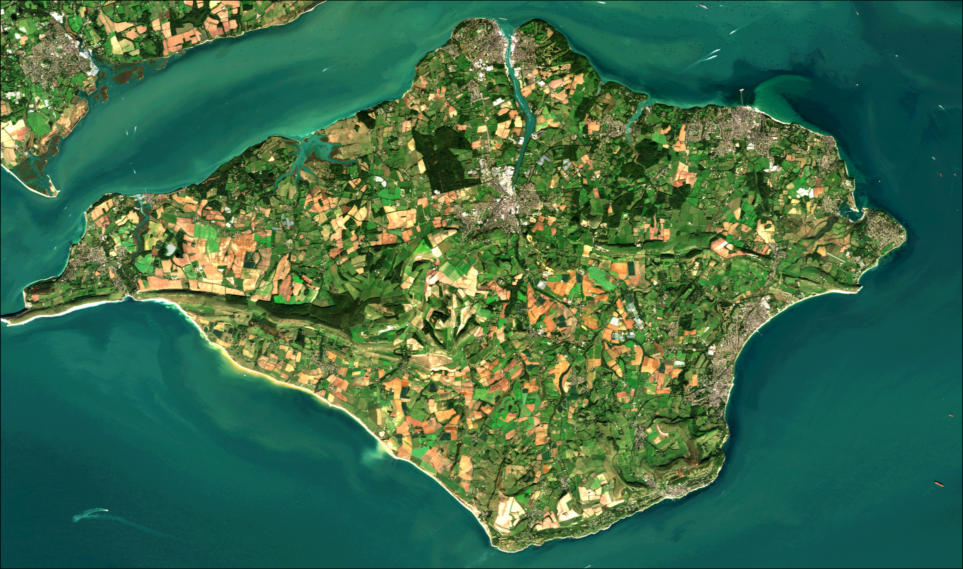

In [3]:
using ImageView, Images
img = load("D:/Julia_Geospatial/Isle_wight.tif")

This image is a 99% clip stretch that I created in rasterio in Python. Julia displays it as if it is a photograph. Have a look at the image and imageviewer packages

# Rasters are just arrays

look what happens when I access a column and row in Julia

In [4]:
img[350,225] ## column and row

In [5]:
img[1000,1] 

Get some information about the array, we will use this knowledge later. Lets print the file size, the type and the shape of the data

In [6]:
sizeof(img)

26221152

In [7]:
typeof(img)

Matrix{RGB{N0f8}} (alias for Array{RGB{Normed{UInt8, 8}}, 2})

In [8]:
size(img) ## this is the equivalent of array.shape() in Python

(2272, 3847)

Now that we have introduced some of the basics and got a feel for Julia's capability lets use ArchGDAL to access this image. Adpated from http://yeesian.com/ArchGDAL.jl/latest/rasters.html

In [9]:
using ArchGDAL; const AG = ArchGDAL
# https://yeesian.com/ArchGDAL.jl/stable/rasters/
dataset = AG.read("D:/Julia_Geospatial/Isle_wight.tif")
typeof(dataset)


ArchGDAL.IDataset

In [10]:
dataset = AG.read("D:/Julia_Geospatial/Isle_wight.tif")

GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  D:/Julia_Geospatial/Isle_wight.tif

Dataset (width x height): 3847 x 2272 (pixels)
Number of raster bands: 3
  [GA_ReadOnly] Band 1 (Red): 3847 x 2272 (UInt8)
  [GA_ReadOnly] Band 2 (Green): 3847 x 2272 (UInt8)
  [GA_ReadOnly] Band 3 (Blue): 3847 x 2272 (UInt8)


Now that we know how to read the data in as a ArchGDAL dataset lets read one band in and plot it. Using the colors package to mimic Python matplotlib.pylot imshow()

In [11]:
band = AG.getband(dataset, 1)

[GA_ReadOnly] Band 1 (Red): 3847 x 2272 (UInt8)
    blocksize: 3847×1, nodata: nothing, units: 1.0px + 0.0
    overviews: 

A new feature of ArchGDAL is imread and it will plot the data for you!

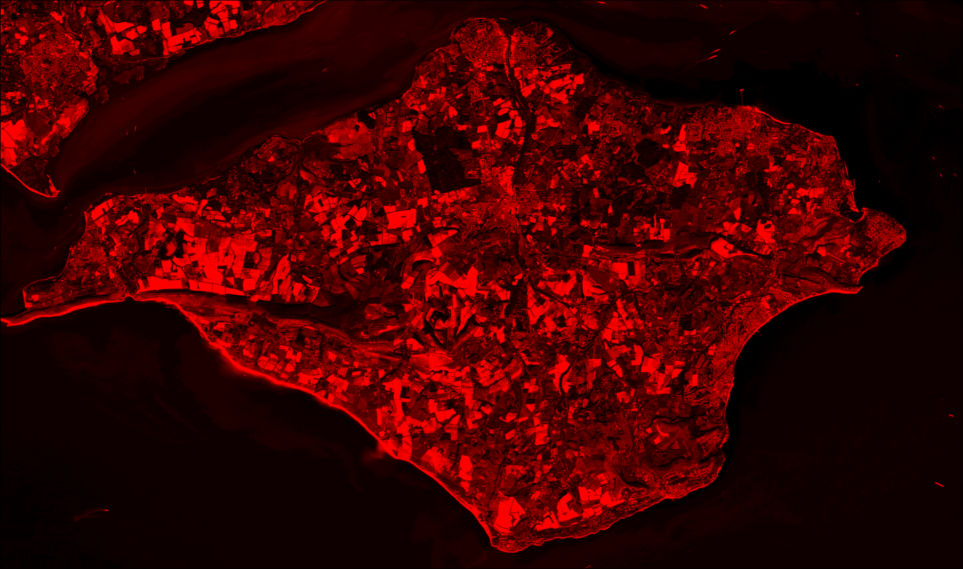

In [12]:
dataset = AG.read("D:/Julia_Geospatial/Isle_wight.tif")
AG.imread(AG.getband(dataset, 1))

imread will plot the rgb image (previous versions - this was a lot of code!)

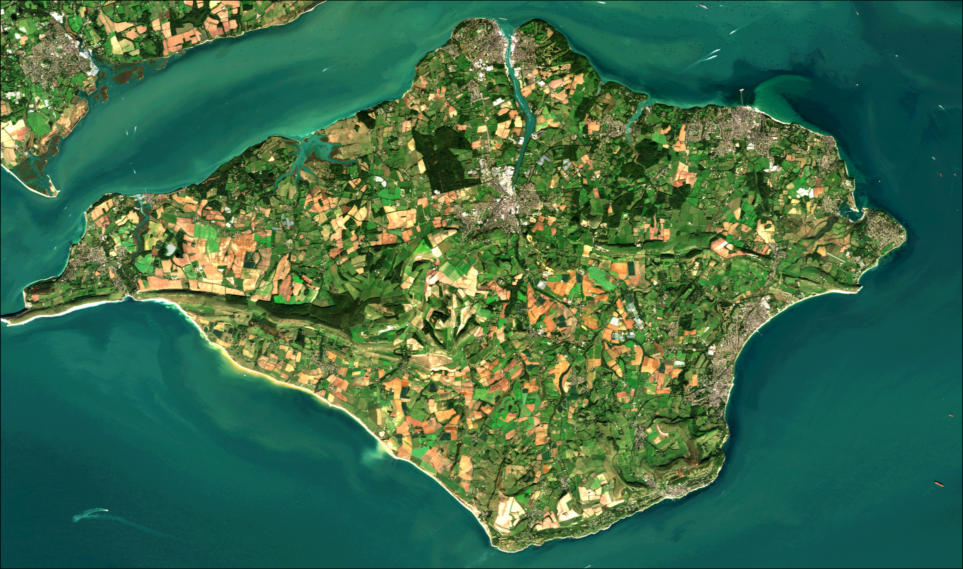

In [13]:
AG.imread(dataset)

False colour image - read each band you need and plot with RGB

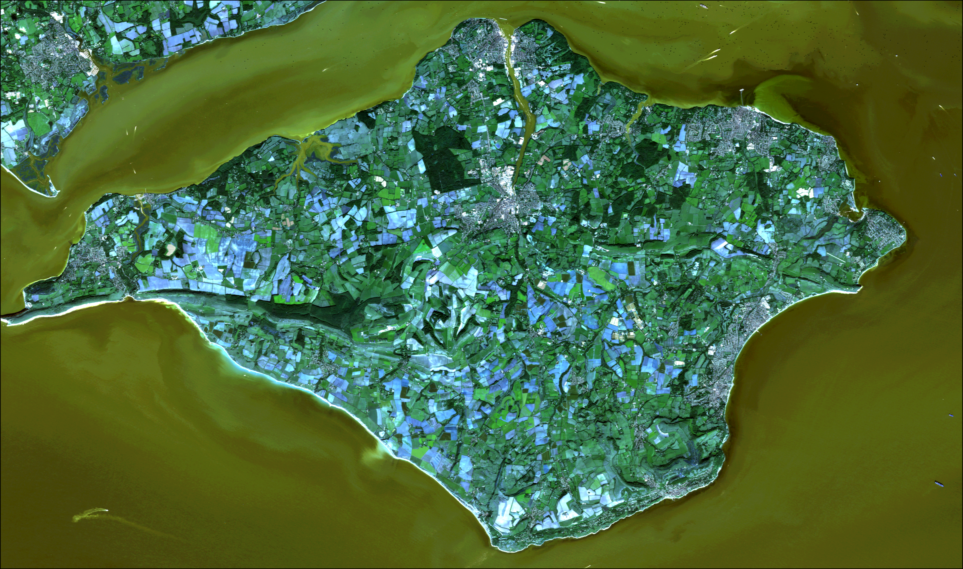

In [14]:
dataset = AG.read("D:/Julia_Geospatial/Isle_wight.tif")
red = AG.getband(dataset, 1)
green = AG.getband(dataset, 2)
blue = AG.getband(dataset, 3)
AG.imview(RGB, blue, green, red)

Another new feature is to access the array directly with .readraster()

In [15]:
raster = AG.readraster("D:/Julia_Geospatial/Isle_wight.tif")
println(typeof(raster))
println(size(raster))

ArchGDAL.RasterDataset{UInt8, ArchGDAL.IDataset}
(3847, 2272, 3)


Finally lets write out a single band of raster data using Julia

In this final example I will need to assign the projection to the output. Otherwise you just get an image. This is a Geospatial tutorial after all

reference https://github.com/yeesian/ArchGDAL.jl/blob/master/test/test_ospy_examples.jl

In [16]:
using ArchGDAL; const AG = ArchGDAL ## make AG the shortcut to ArchGDAL, by doing this I call AG. rather than ArchGDAL.

AG.read("D:/Julia_Geospatial/Isle_wight.tif") do dataset
band1 = AG.getband(dataset,1) ## read in 1 band
ref = AG.getproj(dataset) ## get the project
new1 = AG.read(band1) ## get the data into an array
geotransform = AG.getgeotransform(dataset) ## get the geotransformation propoerties
println(geotransform)
println("projection:")
println(ref)
    
raster = AG.create(
    "band1.tif",
    driver = AG.getdriver("GTiff"),
    width = AG.width(dataset),
    height = AG.height(dataset),
    nbands = 1,
    dtype = UInt8
)
## assign the projection and transformation parameters
AG.setgeotransform!(raster, geotransform)
AG.setproj!(raster, ref)

## write the raster    
AG.write!(
    raster,
    new1,  # image to "burn" into the raster
    1,      # update band 1
)
AG.destroy(raster)
end


[600140.0, 10.0, 0.0, 5.626e6, 0.0, -10.0]
projection:
PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


lets read the image back in to check (but probably best in a GIS - use QGIS 3!)

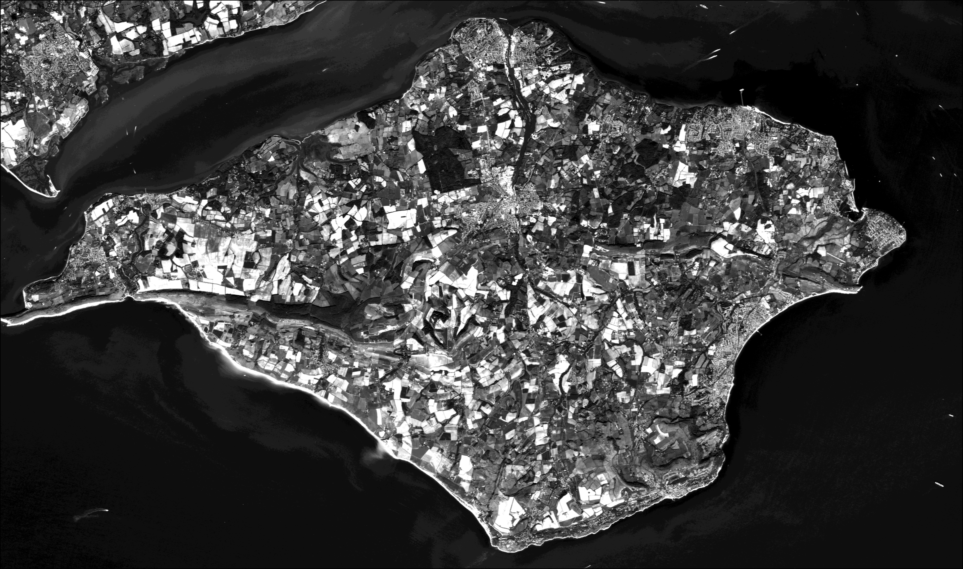

In [17]:
using ArchGDAL; const AG = ArchGDAL
AG.imread("band1.tif")